In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
working_folder='/content/drive/MyDrive/TransformersCode/05-Service_Center/'

In [4]:
!pip install datasets
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.0 MB/s eta 0:00:00


In [5]:
from datasets import *

In [6]:
preprocessed_train_ds = load_from_disk(working_folder  + 'preprocessed_train_dataset')
preprocessed_val_ds = load_from_disk(working_folder  + 'preprocessed_val_dataset')
preprocessed_test_ds = load_from_disk(working_folder  + 'preprocessed_test_dataset')

In [7]:
preprocessed_train_ds

Dataset({
    features: ['label', 'img', 'pixel_values'],
    num_rows: 6104
})

In [8]:
preprocessed_val_ds

Dataset({
    features: ['label', 'img', 'pixel_values'],
    num_rows: 784
})

In [9]:
preprocessed_test_ds

Dataset({
    features: ['label', 'img', 'pixel_values'],
    num_rows: 770
})

In [10]:
model_id='google/vit-base-patch16-224-in21k'

In [11]:
import torch
import torch.nn as nn
from transformers import ViTModel
from transformers.modeling_outputs import SequenceClassifierOutput

In [12]:
class ViTForImageClassification(nn.Module):

    def __init__(self, num_labels=7):

        super(ViTForImageClassification, self).__init__()

        self.vit = ViTModel.from_pretrained(model_id)

        self.dropout = nn.Dropout(0.1)

        self.classifier = nn.Linear(self.vit.config.hidden_size, num_labels)

        self.num_labels = num_labels

    def forward(self, pixel_values, labels=None):

        outputs = self.vit(pixel_values=pixel_values)

        output = self.dropout(outputs.last_hidden_state[:, 0])

        logits = self.classifier(output)
        if labels is not None:

          if isinstance(labels, list):
            labels = torch.tensor(labels, dtype=torch.long, device=logits.device)

          loss_fct = nn.CrossEntropyLoss()
          pred_logits = logits.view(-1, self.num_labels)
          actual_labels = labels.view(-1)
          loss = loss_fct(pred_logits, actual_labels)

          return SequenceClassifierOutput(
              loss=loss,
              logits=logits,
              hidden_states=outputs.hidden_states,
              attentions=outputs.attentions,
          )
        else:
          return logits

In [13]:
from transformers import TrainingArguments, Trainer

In [14]:
metric_name = "accuracy"

args = TrainingArguments(
    output_dir= "output-fer",
    eval_strategy = "epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=8,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    report_to="none"
)

In [16]:
from evaluate import load
import numpy as np
metric = load("accuracy", trust_remote_code=True)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [17]:
model = ViTForImageClassification()

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [18]:
trainer = Trainer(
    model = model,
    args = args,
    train_dataset = preprocessed_train_ds,
    eval_dataset = preprocessed_val_ds,
    compute_metrics = compute_metrics,
)

In [19]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.222376,0.594388
2,1.435300,1.053917,0.623724
3,0.902900,1.062037,0.623724
4,0.633000,0.988194,0.647959
5,0.633000,1.019606,0.663265
6,0.399500,1.024968,0.656888
7,0.251000,1.051927,0.654337
8,0.163600,1.069349,0.667092


TrainOutput(global_step=3056, training_loss=0.6224678686151954, metrics={'train_runtime': 3571.3249, 'train_samples_per_second': 13.673, 'train_steps_per_second': 0.856, 'total_flos': 0.0, 'train_loss': 0.6224678686151954, 'epoch': 8.0})

In [20]:
outputs = trainer.predict(preprocessed_test_ds)
accuracy_result = compute_metrics((outputs.predictions, outputs.label_ids))

print("Test Accuracy:", round(100*accuracy_result["accuracy"],2))

Test Accuracy: 66.1


In [21]:
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
y_true= outputs.label_ids
y_pred=outputs.predictions.argmax(1)
cm = confusion_matrix(y_true, y_pred)

In [24]:
classes_names = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise', 'Neutral']

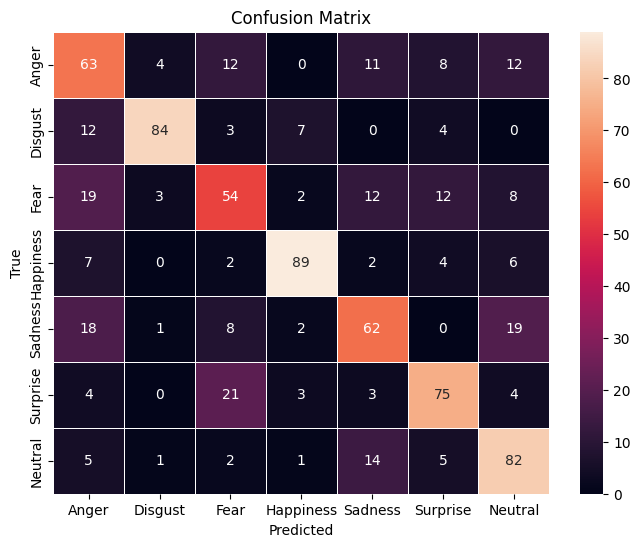

In [25]:
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, xticklabels=classes_names, yticklabels=classes_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [26]:
torch.save(model, working_folder + 'ViT_fine_Tuned_FED')